# Deep Learning: Laparoscopic segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import model
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import math

c:\Users\angel\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Descomentar la siguiente linea si tu ordenador no tiene una GPU NVIDIA, y deseas que el código funcione en una CPU en lugar de una GPU
#torch.cuda.is_available(), torch.cuda.get_device_name(0)   

In [4]:
SEED = 17
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
# determine the device to be used for training and evaluation
DEVICE = "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 5e-4
NUM_EPOCHS = 100
BATCH_SIZE = 45
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

CLASS_WEIGHTS = [2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03]

## Data preparation.

In [6]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [7]:
# https://gist.github.com/IdeaKing/11cf5e146d23c5bb219ba3508cca89ec
def resize_with_pad(image: np.array, 
                    new_shape, 
                    padding_color = (0, 0, 0)) -> np.array:
    """Maintains aspect ratio and resizes with padding.
    Params:
        image: Image to be resized.
        new_shape: Expected (width, height) of new image.
        padding_color: Tuple in BGR of padding color
    Returns:
        image: Resized image with padding
    """
    original_shape = (image.shape[1], image.shape[0])
    ratio = float(max(new_shape))/max(original_shape)
    new_size = tuple([int(x*ratio) for x in original_shape])
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_NEAREST)
    delta_w = new_shape[0] - new_size[0]
    delta_h = new_shape[1] - new_size[1]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)
    image = cv2.copyMakeBorder(image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=padding_color)
    return image

In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 120:-120,:]
		image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 120:-120,:]
		mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = model.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.DiceLoss(class_weights=CLASS_WEIGHTS).cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = math.ceil(len(trainDS) / BATCH_SIZE)
testSteps = math.ceil(len(testDS) / BATCH_SIZE)
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
import time
import torch
from tqdm import tqdm
import torch.nn as nn  # Asegúrate de importar nn

# Define el dispositivo como CPU
DEVICE = torch.device('cpu')

bestIoU = 0

# loop over epochs
print("[INFO] training the network...")
startTime = time.time()

# Define la función de pérdida como CrossEntropyLoss
lossFunc = nn.CrossEntropyLoss()

for e in range(NUM_EPOCHS):
    # set the model in training mode
    uformer.train()
    
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    totalTrainIoU = 0
    totalTestIoU = 0
    totalTrainDC = 0
    totalTestDC = 0
    
    # loop over the training set
    for i, (x, y) in enumerate(tqdm(trainLoader)):
        # send the input to the device (CPU in this case)
        x, y = x.to(DEVICE), y.to(DEVICE)
        
        # perform a forward pass and calculate the training loss
        pred = uformer(x)
        assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
        pred = softmax(pred)
        
        # Calcula la pérdida utilizando CrossEntropyLoss
        loss = lossFunc(pred, y.argmax(dim=1))  # Asume que y es un tensor one-hot
        
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        # add the loss to the total training loss so far
        totalTrainLoss += loss
        totalTrainIoU += iouMetric(pred, y)
        totalTrainDC += gdlMetric(pred, y)
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        uformer.eval()
        
        # loop over the validation set
        for (x, y) in testLoader:
            # send the input to the device (CPU in this case)
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            
            # make the predictions and calculate the validation loss
            pred = uformer(x)
            assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
            pred = softmax(pred)
            
            # Calcula la pérdida utilizando CrossEntropyLoss
            loss = lossFunc(pred, y.argmax(dim=1))  # Asume que y es un tensor one-hot
            
            totalTestLoss += loss
            totalTestIoU += iouMetric(pred, y)
            totalTestDC += gdlMetric(pred, y)
    
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    avgTrainIoU = totalTrainIoU / trainSteps
    avgTestIoU = totalTestIoU / testSteps
    avgTrainDC = totalTrainDC / trainSteps
    avgTestDC = totalTestDC / testSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
    H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
    H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
    H["test_DC"].append(avgTestDC.cpu().detach().numpy())

    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

    if avgTestIoU > bestIoU:
        bestIoU = avgTestIoU
        torch.save(uformer.state_dict(), '../models/uformer_diceLoss.pth')
        print('Best IoU improved. Model saved.')

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))
print(f'Best IoU is: {bestIoU:.5f}')


[INFO] training the network...


100%|██████████| 144/144 [31:05<00:00, 12.95s/it]


[INFO] EPOCH: 1/100
Train loss: 2.159873, Test loss: 1.9644, Train IoU: 0.3775, Test IoU: 0.5695, Train Dice: 0.5224, Test Dice: 0.7220
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:11<00:00, 13.00s/it]


[INFO] EPOCH: 2/100
Train loss: 1.916561, Test loss: 1.8889, Train IoU: 0.6316, Test IoU: 0.6685, Train Dice: 0.7702, Test Dice: 0.7983
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:12<00:00, 13.00s/it]


[INFO] EPOCH: 3/100
Train loss: 1.881751, Test loss: 1.8742, Train IoU: 0.6781, Test IoU: 0.6889, Train Dice: 0.8057, Test Dice: 0.8134
Best IoU improved. Model saved.


100%|██████████| 144/144 [30:27<00:00, 12.69s/it]


[INFO] EPOCH: 4/100
Train loss: 1.869159, Test loss: 1.8648, Train IoU: 0.6959, Test IoU: 0.7022, Train Dice: 0.8186, Test Dice: 0.8231
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:02<00:00, 12.93s/it]


[INFO] EPOCH: 5/100
Train loss: 1.863743, Test loss: 1.8603, Train IoU: 0.7034, Test IoU: 0.7085, Train Dice: 0.8242, Test Dice: 0.8277
Best IoU improved. Model saved.


100%|██████████| 144/144 [30:54<00:00, 12.88s/it]


[INFO] EPOCH: 6/100
Train loss: 1.860401, Test loss: 1.8584, Train IoU: 0.7080, Test IoU: 0.7110, Train Dice: 0.8276, Test Dice: 0.8296
Best IoU improved. Model saved.


100%|██████████| 144/144 [30:13<00:00, 12.59s/it]


[INFO] EPOCH: 7/100
Train loss: 1.857907, Test loss: 1.8563, Train IoU: 0.7116, Test IoU: 0.7140, Train Dice: 0.8302, Test Dice: 0.8319
Best IoU improved. Model saved.


100%|██████████| 144/144 [27:54<00:00, 11.63s/it]


[INFO] EPOCH: 8/100
Train loss: 1.855943, Test loss: 1.8557, Train IoU: 0.7144, Test IoU: 0.7147, Train Dice: 0.8322, Test Dice: 0.8324
Best IoU improved. Model saved.


100%|██████████| 144/144 [28:43<00:00, 11.97s/it]


[INFO] EPOCH: 9/100
Train loss: 1.857094, Test loss: 1.8551, Train IoU: 0.7126, Test IoU: 0.7156, Train Dice: 0.8311, Test Dice: 0.8330
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:02<00:00, 12.93s/it]


[INFO] EPOCH: 10/100
Train loss: 1.853960, Test loss: 1.8537, Train IoU: 0.7172, Test IoU: 0.7175, Train Dice: 0.8342, Test Dice: 0.8344
Best IoU improved. Model saved.


100%|██████████| 144/144 [28:55<00:00, 12.05s/it]


[INFO] EPOCH: 11/100
Train loss: 1.852814, Test loss: 1.8526, Train IoU: 0.7187, Test IoU: 0.7190, Train Dice: 0.8353, Test Dice: 0.8355
Best IoU improved. Model saved.


100%|██████████| 144/144 [29:10<00:00, 12.16s/it]


[INFO] EPOCH: 12/100
Train loss: 1.852291, Test loss: 1.8517, Train IoU: 0.7195, Test IoU: 0.7203, Train Dice: 0.8358, Test Dice: 0.8363
Best IoU improved. Model saved.


100%|██████████| 144/144 [30:24<00:00, 12.67s/it]


[INFO] EPOCH: 13/100
Train loss: 1.851536, Test loss: 1.8518, Train IoU: 0.7205, Test IoU: 0.7201, Train Dice: 0.8365, Test Dice: 0.8362


100%|██████████| 144/144 [30:24<00:00, 12.67s/it]


[INFO] EPOCH: 14/100
Train loss: 1.851463, Test loss: 1.8520, Train IoU: 0.7204, Test IoU: 0.7196, Train Dice: 0.8365, Test Dice: 0.8360


100%|██████████| 144/144 [30:19<00:00, 12.64s/it]


[INFO] EPOCH: 15/100
Train loss: 1.850764, Test loss: 1.8508, Train IoU: 0.7214, Test IoU: 0.7212, Train Dice: 0.8371, Test Dice: 0.8371
Best IoU improved. Model saved.


100%|██████████| 144/144 [30:56<00:00, 12.89s/it]


[INFO] EPOCH: 16/100
Train loss: 1.850171, Test loss: 1.8502, Train IoU: 0.7220, Test IoU: 0.7217, Train Dice: 0.8375, Test Dice: 0.8374
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:14<00:00, 13.02s/it]


[INFO] EPOCH: 17/100
Train loss: 1.849551, Test loss: 1.8494, Train IoU: 0.7227, Test IoU: 0.7225, Train Dice: 0.8379, Test Dice: 0.8379
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:25<00:00, 13.10s/it]


[INFO] EPOCH: 18/100
Train loss: 1.803991, Test loss: 1.7943, Train IoU: 0.7951, Test IoU: 0.8104, Train Dice: 0.8842, Test Dice: 0.8942
Best IoU improved. Model saved.


100%|██████████| 144/144 [31:34<00:00, 13.15s/it]


[INFO] EPOCH: 19/100
Train loss: 1.793222, Test loss: 1.7922, Train IoU: 0.8121, Test IoU: 0.8137, Train Dice: 0.8952, Test Dice: 0.8964
Best IoU improved. Model saved.


100%|██████████| 144/144 [32:12<00:00, 13.42s/it]


[INFO] EPOCH: 20/100
Train loss: 1.790473, Test loss: 1.7920, Train IoU: 0.8165, Test IoU: 0.8139, Train Dice: 0.8981, Test Dice: 0.8966
Best IoU improved. Model saved.


100%|██████████| 144/144 [33:16<00:00, 13.86s/it]


[INFO] EPOCH: 21/100
Train loss: 1.788765, Test loss: 1.7896, Train IoU: 0.8192, Test IoU: 0.8177, Train Dice: 0.8998, Test Dice: 0.8990
Best IoU improved. Model saved.


100%|██████████| 144/144 [33:53<00:00, 14.12s/it]


[INFO] EPOCH: 22/100
Train loss: 1.784778, Test loss: 1.7785, Train IoU: 0.8261, Test IoU: 0.8367, Train Dice: 0.9037, Test Dice: 0.9101
Best IoU improved. Model saved.


100%|██████████| 144/144 [34:41<00:00, 14.45s/it]


[INFO] EPOCH: 23/100
Train loss: 1.776016, Test loss: 1.7747, Train IoU: 0.8408, Test IoU: 0.8428, Train Dice: 0.9126, Test Dice: 0.9139
Best IoU improved. Model saved.


100%|██████████| 144/144 [35:26<00:00, 14.77s/it]


[INFO] EPOCH: 24/100
Train loss: 1.774094, Test loss: 1.7743, Train IoU: 0.8438, Test IoU: 0.8434, Train Dice: 0.9145, Test Dice: 0.9144
Best IoU improved. Model saved.


100%|██████████| 144/144 [37:03<00:00, 15.44s/it]


[INFO] EPOCH: 25/100
Train loss: 1.772611, Test loss: 1.7727, Train IoU: 0.8463, Test IoU: 0.8461, Train Dice: 0.9160, Test Dice: 0.9160
Best IoU improved. Model saved.


100%|██████████| 144/144 [38:18<00:00, 15.96s/it]


[INFO] EPOCH: 26/100
Train loss: 1.772251, Test loss: 1.7727, Train IoU: 0.8468, Test IoU: 0.8460, Train Dice: 0.9164, Test Dice: 0.9159


100%|██████████| 144/144 [40:16<00:00, 16.78s/it]


[INFO] EPOCH: 27/100
Train loss: 1.771783, Test loss: 1.7717, Train IoU: 0.8475, Test IoU: 0.8477, Train Dice: 0.9169, Test Dice: 0.9169
Best IoU improved. Model saved.


100%|██████████| 144/144 [41:59<00:00, 17.50s/it]


[INFO] EPOCH: 28/100
Train loss: 1.771149, Test loss: 1.7723, Train IoU: 0.8487, Test IoU: 0.8466, Train Dice: 0.9175, Test Dice: 0.9163


100%|██████████| 144/144 [43:54<00:00, 18.29s/it]


[INFO] EPOCH: 29/100
Train loss: 1.770504, Test loss: 1.7710, Train IoU: 0.8497, Test IoU: 0.8489, Train Dice: 0.9182, Test Dice: 0.9177
Best IoU improved. Model saved.


100%|██████████| 144/144 [45:19<00:00, 18.88s/it]


[INFO] EPOCH: 30/100
Train loss: 1.769692, Test loss: 1.7705, Train IoU: 0.8511, Test IoU: 0.8497, Train Dice: 0.9189, Test Dice: 0.9181
Best IoU improved. Model saved.


100%|██████████| 144/144 [47:04<00:00, 19.61s/it]


[INFO] EPOCH: 31/100
Train loss: 1.766399, Test loss: 1.7639, Train IoU: 0.8571, Test IoU: 0.8613, Train Dice: 0.9221, Test Dice: 0.9247
Best IoU improved. Model saved.


100%|██████████| 144/144 [49:25<00:00, 20.59s/it]


[INFO] EPOCH: 32/100
Train loss: 1.760080, Test loss: 1.7604, Train IoU: 0.8679, Test IoU: 0.8673, Train Dice: 0.9285, Test Dice: 0.9282
Best IoU improved. Model saved.


100%|██████████| 144/144 [51:19<00:00, 21.38s/it]


[INFO] EPOCH: 33/100
Train loss: 1.758175, Test loss: 1.7619, Train IoU: 0.8712, Test IoU: 0.8647, Train Dice: 0.9304, Test Dice: 0.9267


100%|██████████| 144/144 [52:48<00:00, 22.01s/it]


[INFO] EPOCH: 34/100
Train loss: 1.757185, Test loss: 1.7565, Train IoU: 0.8729, Test IoU: 0.8741, Train Dice: 0.9314, Test Dice: 0.9322
Best IoU improved. Model saved.


100%|██████████| 144/144 [53:35<00:00, 22.33s/it]


[INFO] EPOCH: 35/100
Train loss: 1.753497, Test loss: 1.7549, Train IoU: 0.8794, Test IoU: 0.8769, Train Dice: 0.9351, Test Dice: 0.9338
Best IoU improved. Model saved.


100%|██████████| 144/144 [53:46<00:00, 22.40s/it]


[INFO] EPOCH: 36/100
Train loss: 1.752774, Test loss: 1.7541, Train IoU: 0.8807, Test IoU: 0.8782, Train Dice: 0.9359, Test Dice: 0.9346
Best IoU improved. Model saved.


100%|██████████| 144/144 [54:22<00:00, 22.66s/it]


[INFO] EPOCH: 37/100
Train loss: 1.752020, Test loss: 1.7533, Train IoU: 0.8819, Test IoU: 0.8796, Train Dice: 0.9366, Test Dice: 0.9353
Best IoU improved. Model saved.


100%|██████████| 144/144 [54:33<00:00, 22.74s/it]


[INFO] EPOCH: 38/100
Train loss: 1.750798, Test loss: 1.7525, Train IoU: 0.8841, Test IoU: 0.8809, Train Dice: 0.9379, Test Dice: 0.9361
Best IoU improved. Model saved.


100%|██████████| 144/144 [54:48<00:00, 22.84s/it]


[INFO] EPOCH: 39/100
Train loss: 1.747872, Test loss: 1.7464, Train IoU: 0.8894, Test IoU: 0.8920, Train Dice: 0.9408, Test Dice: 0.9423
Best IoU improved. Model saved.


100%|██████████| 144/144 [55:38<00:00, 23.18s/it]


[INFO] EPOCH: 40/100
Train loss: 1.744407, Test loss: 1.7451, Train IoU: 0.8955, Test IoU: 0.8942, Train Dice: 0.9442, Test Dice: 0.9435
Best IoU improved. Model saved.


100%|██████████| 144/144 [57:54<00:00, 24.13s/it]


[INFO] EPOCH: 41/100
Train loss: 1.743707, Test loss: 1.7457, Train IoU: 0.8968, Test IoU: 0.8930, Train Dice: 0.9449, Test Dice: 0.9429


100%|██████████| 144/144 [58:04<00:00, 24.20s/it]


[INFO] EPOCH: 42/100
Train loss: 1.742691, Test loss: 1.7398, Train IoU: 0.8986, Test IoU: 0.9039, Train Dice: 0.9459, Test Dice: 0.9488
Best IoU improved. Model saved.


100%|██████████| 144/144 [56:29<00:00, 23.54s/it]


[INFO] EPOCH: 43/100
Train loss: 1.734823, Test loss: 1.7346, Train IoU: 0.9130, Test IoU: 0.9132, Train Dice: 0.9538, Test Dice: 0.9541
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:01:02<00:00, 25.44s/it]


[INFO] EPOCH: 44/100
Train loss: 1.732420, Test loss: 1.7335, Train IoU: 0.9173, Test IoU: 0.9151, Train Dice: 0.9563, Test Dice: 0.9552
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:01:41<00:00, 25.70s/it]


[INFO] EPOCH: 45/100
Train loss: 1.731202, Test loss: 1.7332, Train IoU: 0.9195, Test IoU: 0.9157, Train Dice: 0.9575, Test Dice: 0.9555
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:04:21<00:00, 26.82s/it]


[INFO] EPOCH: 46/100
Train loss: 1.724312, Test loss: 1.7178, Train IoU: 0.9325, Test IoU: 0.9448, Train Dice: 0.9644, Test Dice: 0.9710
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:05:46<00:00, 27.41s/it]


[INFO] EPOCH: 47/100
Train loss: 1.714517, Test loss: 1.7140, Train IoU: 0.9509, Test IoU: 0.9518, Train Dice: 0.9742, Test Dice: 0.9748
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:04:58<00:00, 27.07s/it]


[INFO] EPOCH: 48/100
Train loss: 1.712477, Test loss: 1.7128, Train IoU: 0.9547, Test IoU: 0.9539, Train Dice: 0.9763, Test Dice: 0.9760
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:05:30<00:00, 27.30s/it]


[INFO] EPOCH: 49/100
Train loss: 1.711543, Test loss: 1.7121, Train IoU: 0.9565, Test IoU: 0.9553, Train Dice: 0.9773, Test Dice: 0.9767
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:06:09<00:00, 27.56s/it]


[INFO] EPOCH: 50/100
Train loss: 1.711517, Test loss: 1.7126, Train IoU: 0.9565, Test IoU: 0.9544, Train Dice: 0.9773, Test Dice: 0.9763


100%|██████████| 144/144 [1:06:56<00:00, 27.89s/it]


[INFO] EPOCH: 51/100
Train loss: 1.711314, Test loss: 1.7128, Train IoU: 0.9568, Test IoU: 0.9539, Train Dice: 0.9775, Test Dice: 0.9760


100%|██████████| 144/144 [1:08:23<00:00, 28.49s/it]


[INFO] EPOCH: 52/100
Train loss: 1.710895, Test loss: 1.7114, Train IoU: 0.9576, Test IoU: 0.9565, Train Dice: 0.9780, Test Dice: 0.9775
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:09:01<00:00, 28.76s/it]


[INFO] EPOCH: 53/100
Train loss: 1.710034, Test loss: 1.7109, Train IoU: 0.9593, Test IoU: 0.9574, Train Dice: 0.9788, Test Dice: 0.9779
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:10:19<00:00, 29.30s/it]


[INFO] EPOCH: 54/100
Train loss: 1.709928, Test loss: 1.7111, Train IoU: 0.9594, Test IoU: 0.9572, Train Dice: 0.9789, Test Dice: 0.9778


100%|██████████| 144/144 [1:11:10<00:00, 29.65s/it]


[INFO] EPOCH: 55/100
Train loss: 1.709420, Test loss: 1.7108, Train IoU: 0.9604, Test IoU: 0.9577, Train Dice: 0.9795, Test Dice: 0.9781
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:11:19<00:00, 29.72s/it]


[INFO] EPOCH: 56/100
Train loss: 1.709120, Test loss: 1.7108, Train IoU: 0.9610, Test IoU: 0.9577, Train Dice: 0.9798, Test Dice: 0.9781
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:13:59<00:00, 30.83s/it]


[INFO] EPOCH: 57/100
Train loss: 1.709352, Test loss: 1.7109, Train IoU: 0.9605, Test IoU: 0.9574, Train Dice: 0.9795, Test Dice: 0.9780


100%|██████████| 144/144 [1:13:37<00:00, 30.68s/it]


[INFO] EPOCH: 58/100
Train loss: 1.708965, Test loss: 1.7112, Train IoU: 0.9612, Test IoU: 0.9570, Train Dice: 0.9799, Test Dice: 0.9777


100%|██████████| 144/144 [1:14:08<00:00, 30.89s/it]


[INFO] EPOCH: 59/100
Train loss: 1.708783, Test loss: 1.7108, Train IoU: 0.9616, Test IoU: 0.9577, Train Dice: 0.9801, Test Dice: 0.9781


100%|██████████| 144/144 [1:17:27<00:00, 32.27s/it]


[INFO] EPOCH: 60/100
Train loss: 1.709089, Test loss: 1.7100, Train IoU: 0.9610, Test IoU: 0.9591, Train Dice: 0.9798, Test Dice: 0.9789
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:19:14<00:00, 33.02s/it]


[INFO] EPOCH: 61/100
Train loss: 1.708168, Test loss: 1.7095, Train IoU: 0.9627, Test IoU: 0.9601, Train Dice: 0.9807, Test Dice: 0.9794
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:14:51<00:00, 31.19s/it]


[INFO] EPOCH: 62/100
Train loss: 1.707846, Test loss: 1.7097, Train IoU: 0.9634, Test IoU: 0.9597, Train Dice: 0.9811, Test Dice: 0.9792


100%|██████████| 144/144 [1:15:31<00:00, 31.47s/it]


[INFO] EPOCH: 63/100
Train loss: 1.708035, Test loss: 1.7095, Train IoU: 0.9630, Test IoU: 0.9602, Train Dice: 0.9809, Test Dice: 0.9795
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:16:30<00:00, 31.88s/it]


[INFO] EPOCH: 64/100
Train loss: 1.707833, Test loss: 1.7096, Train IoU: 0.9634, Test IoU: 0.9600, Train Dice: 0.9811, Test Dice: 0.9794


100%|██████████| 144/144 [1:16:56<00:00, 32.06s/it]


[INFO] EPOCH: 65/100
Train loss: 1.707564, Test loss: 1.7089, Train IoU: 0.9639, Test IoU: 0.9612, Train Dice: 0.9814, Test Dice: 0.9800
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:18:02<00:00, 32.51s/it]


[INFO] EPOCH: 66/100
Train loss: 1.708085, Test loss: 1.7097, Train IoU: 0.9629, Test IoU: 0.9597, Train Dice: 0.9808, Test Dice: 0.9792


100%|██████████| 144/144 [1:18:47<00:00, 32.83s/it]


[INFO] EPOCH: 67/100
Train loss: 1.707798, Test loss: 1.7097, Train IoU: 0.9634, Test IoU: 0.9597, Train Dice: 0.9811, Test Dice: 0.9792


100%|██████████| 144/144 [1:19:16<00:00, 33.03s/it]


[INFO] EPOCH: 68/100
Train loss: 1.707573, Test loss: 1.7089, Train IoU: 0.9638, Test IoU: 0.9612, Train Dice: 0.9813, Test Dice: 0.9800
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:17:55<00:00, 32.47s/it]


[INFO] EPOCH: 69/100
Train loss: 1.707086, Test loss: 1.7089, Train IoU: 0.9648, Test IoU: 0.9613, Train Dice: 0.9818, Test Dice: 0.9801
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:17:46<00:00, 32.41s/it]


[INFO] EPOCH: 70/100
Train loss: 1.706972, Test loss: 1.7089, Train IoU: 0.9650, Test IoU: 0.9612, Train Dice: 0.9820, Test Dice: 0.9800


100%|██████████| 144/144 [1:17:54<00:00, 32.46s/it]


[INFO] EPOCH: 71/100
Train loss: 1.706678, Test loss: 1.7091, Train IoU: 0.9656, Test IoU: 0.9609, Train Dice: 0.9823, Test Dice: 0.9798


100%|██████████| 144/144 [1:17:55<00:00, 32.47s/it]


[INFO] EPOCH: 72/100
Train loss: 1.706912, Test loss: 1.7090, Train IoU: 0.9651, Test IoU: 0.9611, Train Dice: 0.9820, Test Dice: 0.9800


100%|██████████| 144/144 [1:21:28<00:00, 33.95s/it]


[INFO] EPOCH: 73/100
Train loss: 1.706761, Test loss: 1.7091, Train IoU: 0.9654, Test IoU: 0.9608, Train Dice: 0.9822, Test Dice: 0.9798


100%|██████████| 144/144 [1:27:53<00:00, 36.62s/it]   


[INFO] EPOCH: 74/100
Train loss: 1.706485, Test loss: 1.7085, Train IoU: 0.9659, Test IoU: 0.9621, Train Dice: 0.9824, Test Dice: 0.9805
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:28:05<00:00, 36.70s/it] 


[INFO] EPOCH: 75/100
Train loss: 1.706505, Test loss: 1.7087, Train IoU: 0.9659, Test IoU: 0.9616, Train Dice: 0.9824, Test Dice: 0.9802


100%|██████████| 144/144 [1:16:17<00:00, 31.79s/it]


[INFO] EPOCH: 76/100
Train loss: 1.708355, Test loss: 1.7115, Train IoU: 0.9624, Test IoU: 0.9562, Train Dice: 0.9806, Test Dice: 0.9774


100%|██████████| 144/144 [1:24:49<00:00, 35.35s/it]


[INFO] EPOCH: 77/100
Train loss: 1.707853, Test loss: 1.7085, Train IoU: 0.9633, Test IoU: 0.9619, Train Dice: 0.9811, Test Dice: 0.9804


100%|██████████| 144/144 [1:20:08<00:00, 33.39s/it]


[INFO] EPOCH: 78/100
Train loss: 1.706331, Test loss: 1.7084, Train IoU: 0.9662, Test IoU: 0.9621, Train Dice: 0.9826, Test Dice: 0.9805
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:18:24<00:00, 32.67s/it]


[INFO] EPOCH: 79/100
Train loss: 1.705937, Test loss: 1.7084, Train IoU: 0.9670, Test IoU: 0.9621, Train Dice: 0.9830, Test Dice: 0.9805


100%|██████████| 144/144 [1:18:37<00:00, 32.76s/it]


[INFO] EPOCH: 80/100
Train loss: 1.705995, Test loss: 1.7083, Train IoU: 0.9669, Test IoU: 0.9624, Train Dice: 0.9829, Test Dice: 0.9807
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:17:17<00:00, 32.20s/it]


[INFO] EPOCH: 81/100
Train loss: 1.705863, Test loss: 1.7081, Train IoU: 0.9671, Test IoU: 0.9629, Train Dice: 0.9831, Test Dice: 0.9809
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:16:14<00:00, 31.77s/it]


[INFO] EPOCH: 82/100
Train loss: 1.709543, Test loss: 1.7281, Train IoU: 0.9603, Test IoU: 0.9249, Train Dice: 0.9794, Test Dice: 0.9606


100%|██████████| 144/144 [1:24:29<00:00, 35.20s/it]


[INFO] EPOCH: 83/100
Train loss: 1.711905, Test loss: 1.7089, Train IoU: 0.9555, Test IoU: 0.9612, Train Dice: 0.9770, Test Dice: 0.9800


100%|██████████| 144/144 [1:19:17<00:00, 33.04s/it]


[INFO] EPOCH: 84/100
Train loss: 1.706279, Test loss: 1.7080, Train IoU: 0.9663, Test IoU: 0.9629, Train Dice: 0.9827, Test Dice: 0.9809


100%|██████████| 144/144 [1:18:42<00:00, 32.79s/it]


[INFO] EPOCH: 85/100
Train loss: 1.705528, Test loss: 1.7077, Train IoU: 0.9678, Test IoU: 0.9636, Train Dice: 0.9834, Test Dice: 0.9813
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:14:31<00:00, 31.05s/it]


[INFO] EPOCH: 86/100
Train loss: 1.705101, Test loss: 1.7076, Train IoU: 0.9686, Test IoU: 0.9637, Train Dice: 0.9838, Test Dice: 0.9813
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:14:14<00:00, 30.94s/it]


[INFO] EPOCH: 87/100
Train loss: 1.705030, Test loss: 1.7079, Train IoU: 0.9688, Test IoU: 0.9632, Train Dice: 0.9839, Test Dice: 0.9811


100%|██████████| 144/144 [1:15:12<00:00, 31.33s/it]


[INFO] EPOCH: 88/100
Train loss: 1.704935, Test loss: 1.7077, Train IoU: 0.9689, Test IoU: 0.9635, Train Dice: 0.9840, Test Dice: 0.9812


100%|██████████| 144/144 [1:14:45<00:00, 31.15s/it]


[INFO] EPOCH: 89/100
Train loss: 1.704905, Test loss: 1.7076, Train IoU: 0.9690, Test IoU: 0.9638, Train Dice: 0.9840, Test Dice: 0.9814
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:15:03<00:00, 31.27s/it]


[INFO] EPOCH: 90/100
Train loss: 1.704882, Test loss: 1.7075, Train IoU: 0.9690, Test IoU: 0.9640, Train Dice: 0.9841, Test Dice: 0.9815
Best IoU improved. Model saved.


100%|██████████| 144/144 [1:13:39<00:00, 30.69s/it]


[INFO] EPOCH: 91/100
Train loss: 1.704844, Test loss: 1.7078, Train IoU: 0.9691, Test IoU: 0.9633, Train Dice: 0.9841, Test Dice: 0.9811


100%|██████████| 144/144 [1:29:35<00:00, 37.33s/it]   


[INFO] EPOCH: 92/100
Train loss: 1.704852, Test loss: 1.7076, Train IoU: 0.9691, Test IoU: 0.9637, Train Dice: 0.9841, Test Dice: 0.9813


100%|██████████| 144/144 [1:15:20<00:00, 31.39s/it]


[INFO] EPOCH: 93/100
Train loss: 1.704955, Test loss: 1.7076, Train IoU: 0.9689, Test IoU: 0.9637, Train Dice: 0.9840, Test Dice: 0.9813


100%|██████████| 144/144 [1:16:43<00:00, 31.97s/it]


[INFO] EPOCH: 94/100
Train loss: 1.705086, Test loss: 1.7083, Train IoU: 0.9686, Test IoU: 0.9624, Train Dice: 0.9839, Test Dice: 0.9807


100%|██████████| 144/144 [1:12:32<00:00, 30.23s/it]


[INFO] EPOCH: 95/100
Train loss: 1.705086, Test loss: 1.7079, Train IoU: 0.9686, Test IoU: 0.9630, Train Dice: 0.9839, Test Dice: 0.9810


100%|██████████| 144/144 [1:13:08<00:00, 30.48s/it]


[INFO] EPOCH: 96/100
Train loss: 1.705032, Test loss: 1.7077, Train IoU: 0.9687, Test IoU: 0.9636, Train Dice: 0.9839, Test Dice: 0.9813


100%|██████████| 144/144 [1:11:09<00:00, 29.65s/it]


[INFO] EPOCH: 97/100
Train loss: 1.705046, Test loss: 1.7077, Train IoU: 0.9687, Test IoU: 0.9634, Train Dice: 0.9839, Test Dice: 0.9812


100%|██████████| 144/144 [1:10:13<00:00, 29.26s/it]


[INFO] EPOCH: 98/100
Train loss: 1.704983, Test loss: 1.7076, Train IoU: 0.9688, Test IoU: 0.9638, Train Dice: 0.9840, Test Dice: 0.9814


100%|██████████| 144/144 [1:09:49<00:00, 29.10s/it]


[INFO] EPOCH: 99/100
Train loss: 1.704895, Test loss: 1.7079, Train IoU: 0.9690, Test IoU: 0.9632, Train Dice: 0.9841, Test Dice: 0.9811


100%|██████████| 144/144 [1:11:57<00:00, 29.98s/it]


[INFO] EPOCH: 100/100
Train loss: 1.704933, Test loss: 1.7078, Train IoU: 0.9689, Test IoU: 0.9633, Train Dice: 0.9840, Test Dice: 0.9812
[INFO] total time taken to train the model: 401595.16s
Best IoU is: 0.96398


In [13]:
# serialize the model to disk
# torch.save(uformer.state_dict(), '../models/uformer_tversky.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

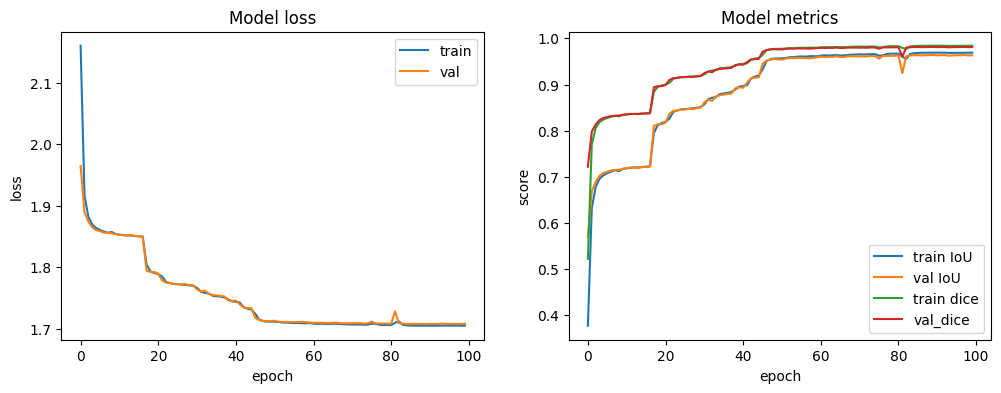

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model metrics')
plt.ylabel('score')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 120:-120,:]
    image = resize_with_pad(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 120:-120,:]
    mask = resize_with_pad(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), (50, 50, 50))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

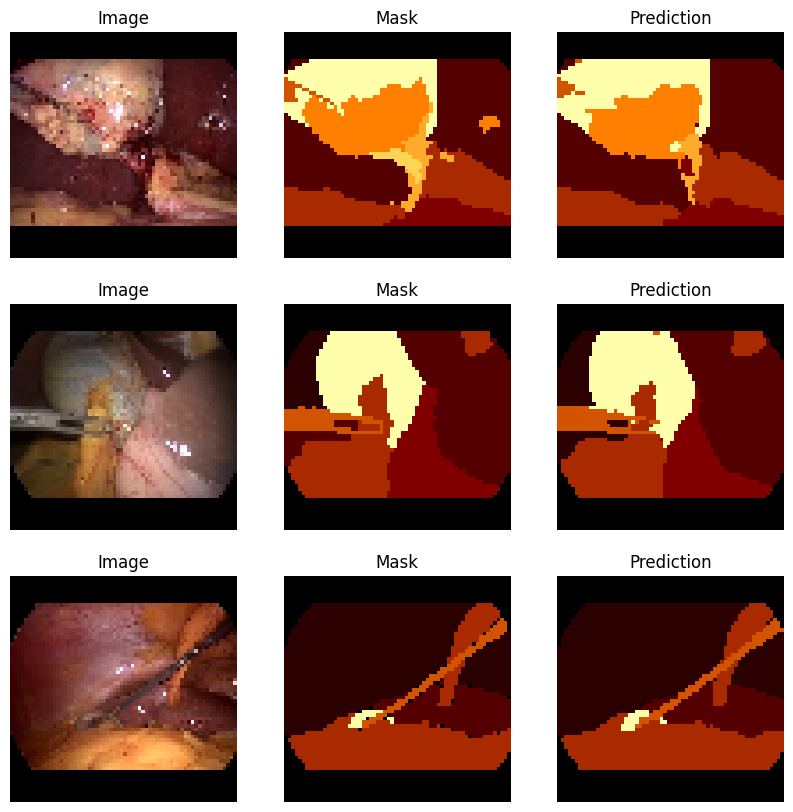

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='afmhot', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

--
**TFG - Adrián Contreras Castillo**
--